In [13]:
import torch
import matplotlib.pyplot as plt
import EIANN.utils as ut
import EIANN.plot as pt

from tqdm.autonotebook import tqdm
import numpy as np
import matplotlib.gridspec as gs
%load_ext autoreload
%autoreload 2

pt.update_plot_defaults()

train_dataloader, train_sub_dataloader, val_dataloader, test_dataloader, data_generator = ut.get_MNIST_dataloaders(sub_dataloader_size=20_000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
saved_network_path = "../data/mnist/20241009_EIANN_2_hidden_mnist_BP_like_config_5J_learn_TD_HWN_1_66049_257_complete.pkl"
trained_network = ut.load_network(saved_network_path)

Loading network from '../data/mnist/20241009_EIANN_2_hidden_mnist_BP_like_config_5J_learn_TD_HWN_1_66049_257_complete.pkl'
Network successfully loaded from '../data/mnist/20241009_EIANN_2_hidden_mnist_BP_like_config_5J_learn_TD_HWN_1_66049_257_complete.pkl'


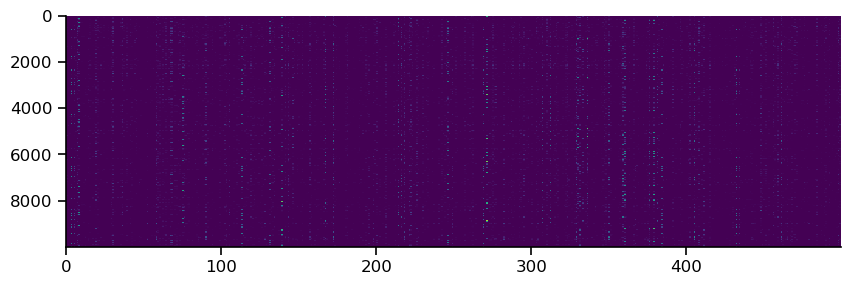

In [18]:
plt.imshow(trained_network.H2.E.activity, aspect="auto", interpolation="nearest")

Batch accuracy = 92.44000244140625%


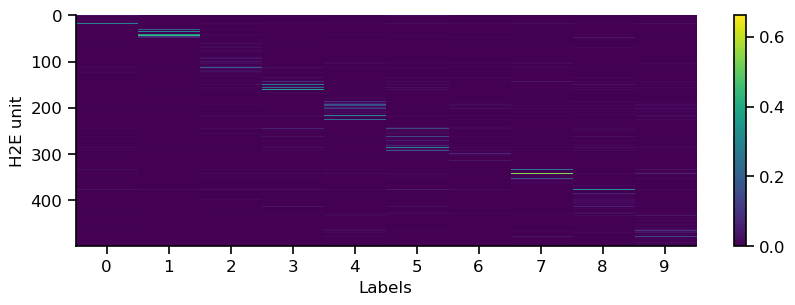

In [19]:
pt.plot_batch_accuracy(trained_network, test_dataloader, population='H2E')

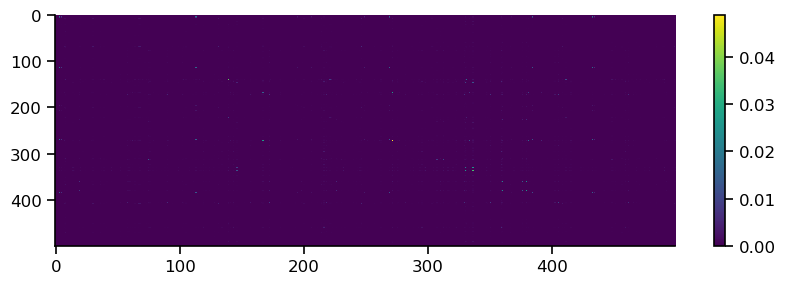

In [20]:
H2_act = trained_network.H2.E.activity
cov_mat = torch.matmul(H2_act.T, H2_act) / H2_act.shape[0]
plt.imshow(cov_mat, aspect="auto", interpolation="nearest")
plt.colorbar()

In [21]:
w = trained_network.Output.E.H2.E.weight.data
# w = torch.empty(10,500).log_normal_(0,2)
pred_B = cov_mat@w.T

cov_matrix = np.cov(H2_act.T)
U, S, V = np.linalg.svd(cov_matrix)
w2 = U[:,0:10].T # Take the first 10 eigenvectors
pred_B2 = cov_mat@w2.T

# plt.scatter(w.flatten(), pred_B.flatten(), s=1)
# plt.xlabel("True weight")
# plt.ylabel("Predicted weight")


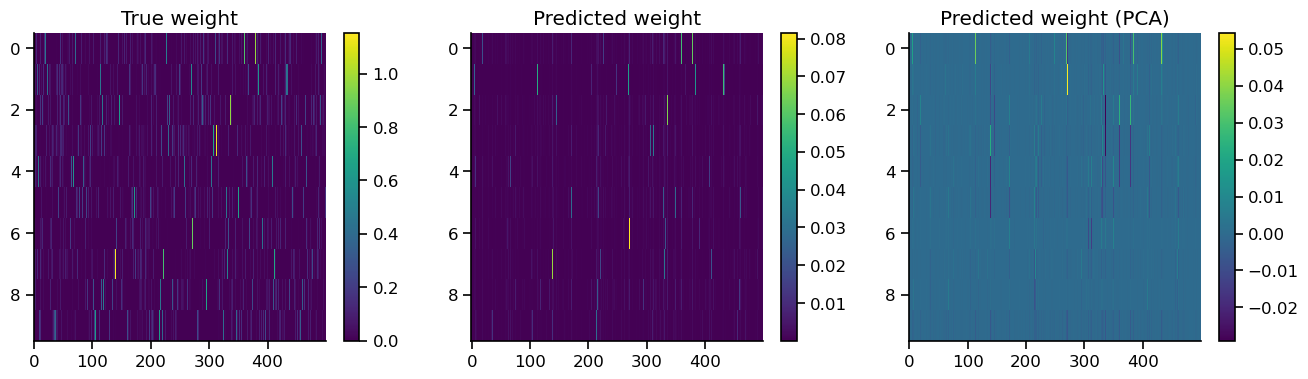

In [22]:
fig,ax  = plt.subplots(1,3, figsize=(16,4))
im = ax[0].imshow(w, aspect="auto", interpolation="nearest")    
ax[0].set_title("True weight")
plt.colorbar(im)

im = ax[1].imshow(pred_B.T, aspect="auto", interpolation="nearest")
ax[1].set_title("Predicted weight")
plt.colorbar(im)

im = ax[2].imshow(pred_B2.T, aspect="auto", interpolation="nearest")
ax[2].set_title("Predicted weight (PCA)")
plt.colorbar(im)

plt.show()

In [150]:
config_path = "../network_config/MNIST_templates/Simple_1layer_learnTD_HWN.yaml"
network = ut.build_EIANN_from_config(config_path, network_seed=66049)

dim = network.Input.E.size
x_ = np.linspace(-5, 5, dim)
mu = 0
std = 1
gaussian = np.exp(-0.5 * ((x_ - mu) / std) ** 2)

data = []
for idx in tqdm(range(1000)):
    # sample_data = torch.empty(dim).log_normal_(0, 1)
    # sample_data = torch.empty(dim).uniform_(-1, 1)
    # sample_data = torch.eye(dim)[torch.randint(0, dim, (1,))].squeeze()
    sample_data = torch.randn(dim)
    # sample_data = torch.tensor(np.roll(gaussian, torch.randint(0, dim, (1,)))).float()

    # trained_network.forward(torch.empty(trained_network.Input.E.size).uniform_(-1, 1))
    # trained_network.forward(torch.eye(trained_network.Input.E.size)[torch.randint(0, trained_network.Input.E.size, (1,))].squeeze())
    # trained_network.forward(torch.randn(trained_network.Input.E.size))
    # sample_data = trained_network.Input.E.activity

    sample_target = torch.rand(network.Output.E.size)
    data.append([idx, sample_data, sample_target])
train_dataloader = torch.utils.data.DataLoader(data, shuffle=True, generator=data_generator, batch_size=1)

network.train(train_dataloader, 
                epochs=1,
                val_interval=(0,-1,1),
                store_history=True, 
                store_params=True,
                status_bar=True)

# FF_FB_angles = ut.compute_feedback_weight_angle_history(network, plot=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

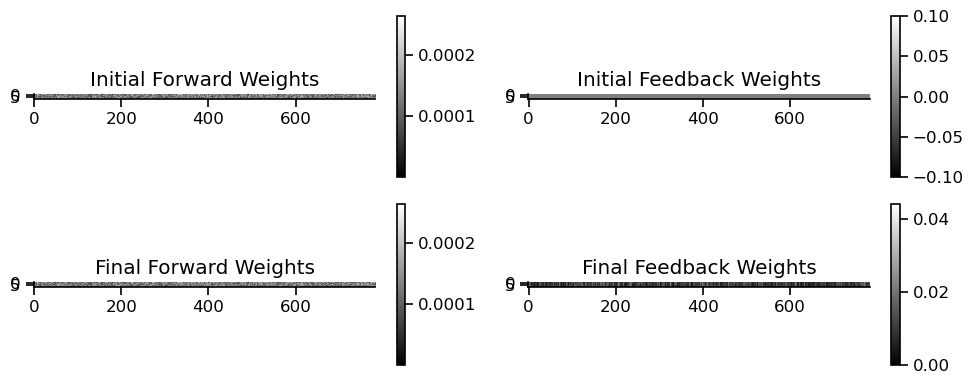

Text(0, 0.5, 'Final Feedback Weights')

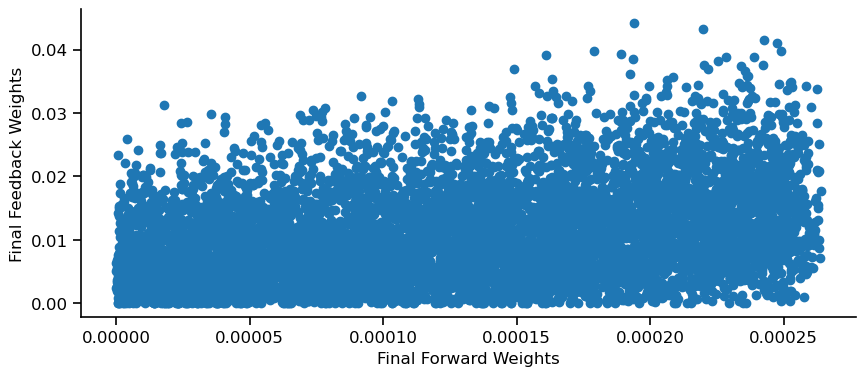

In [151]:
init_F = network.param_history[0]['module_dict.OutputE_InputE.weight']
init_B = network.param_history[0]['module_dict.InputE_OutputE.weight'].T
final_F = network.param_history[-1]['module_dict.OutputE_InputE.weight']
final_B = network.param_history[-1]['module_dict.InputE_OutputE.weight'].T

fig, ax  = plt.subplots(2,2, figsize=(10,4))
im = ax[0,0].imshow(init_F, cmap='gray')
ax[0,0].set_title("Initial Forward Weights")
cbar = fig.colorbar(im, ax=ax[0,0])
im = ax[0,1].imshow(init_B, cmap='gray')
ax[0,1].set_title("Initial Feedback Weights")
cbar = fig.colorbar(im, ax=ax[0,1])
im = ax[1,0].imshow(final_F, cmap='gray')
ax[1,0].set_title("Final Forward Weights")
cbar = fig.colorbar(im, ax=ax[1,0])
im = ax[1,1].imshow(final_B, cmap='gray')
ax[1,1].set_title("Final Feedback Weights")
cbar = fig.colorbar(im, ax=ax[1,1])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,4))
plt.scatter(final_F.flatten(), final_B.flatten())
plt.xlabel("Final Forward Weights")
plt.ylabel("Final Feedback Weights")

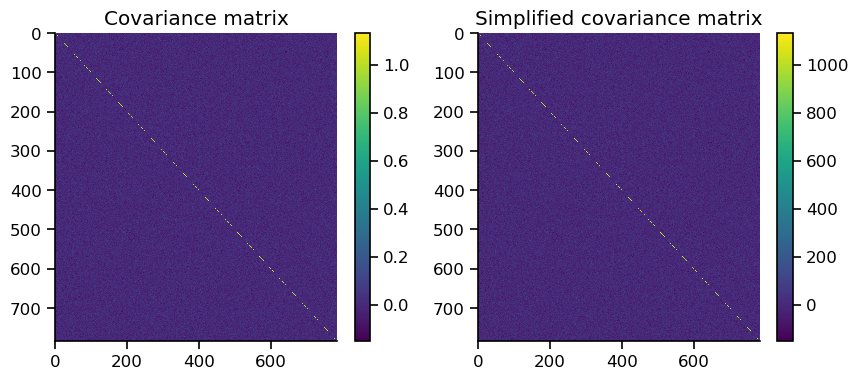

In [152]:
act = network.Input.E.activity_history
cov_mat1 = np.cov(act.T)
cov_mat2 = np.matmul(act.T, act)

fig, ax = plt.subplots(1,2, figsize=(10,4))
im = ax[0].imshow(cov_mat1, aspect="auto", interpolation="nearest")
ax[0].set_title("Covariance matrix")
plt.colorbar(im, ax=ax[0])

im = ax[1].imshow(cov_mat2, aspect="auto", interpolation="nearest")
ax[1].set_title("Simplified covariance matrix")
plt.colorbar(im, ax=ax[1])
plt.show()

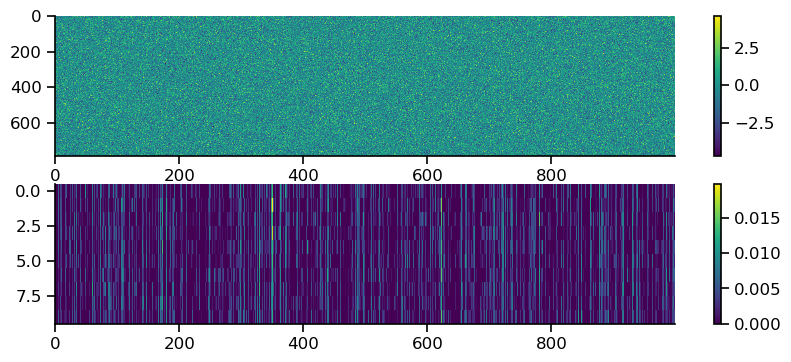

In [153]:
fig, ax = plt.subplots(2,1, figsize=(10,4))

im = ax[0].imshow(network.Input.E.activity_history.T, aspect='auto', interpolation='nearest')
cbar = fig.colorbar(im, ax=ax[0])

im = ax[1].imshow(network.Output.E.activity_history.T, aspect='auto', interpolation='nearest')
cbar = fig.colorbar(im, ax=ax[1])
